# 1.この課題の目的
実データに近いものの学習推定を行う
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.信用情報
Week3でEDAを行ったKaggleの Home Credit Default Risk コンペティションの学習および推定を行います。データはWeek3でEDAを行ったものを使用してください。

# 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。
## ①前処理
- カテゴリカル変数をget_dummyメソッドにてOneHotEncoding
- 欠損値はゼロ補完
- 目的変数(TARGET)と相関係数の高い特徴量上位10個を学習データとする
- train_test_splitメソッドにてtrainデータを学習データ75%、テストデータ25%で分割

## ②モデル作成・評価
- 下記処理をパイプラインで定義
    1. StandardScalerクラスによる正規化
    2. PCAクラスによる次元削減
    3. KNeighborsClassifierモデルを使用


- パイプラインクラスのインスタンスに学習データから分割したX_train,y_trainを投入しモデル作成

- predictメソッドにy_testを投入し、予測値(目的変数TARGETが1 or 0)を求める

- 以下の評価値にて学習モデルを評価する
    1. accuracy score
    2. precision score
    3. recall score
    4. f1 score
    

- predict_provaメソッドを使用しapplication_test.csvのデータを投入し、目的変数TARGETが「1」(ローン未完済)の予測確率を計算

    

    
    


In [84]:
import pandas as pd
import numpy as np

## 各機械学習モデルを作成する為に必要なクラスをインポート
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# 画像を表示する為のクラスをインポート
from IPython.display import Image, display_png
from PIL import Image

## <u>データ準備</u>

In [2]:
# テストデータを読み込み、先頭から５行のみ表示
df = pd.read_csv('application_train.csv') # train.csvをデータフレーム形式で読み込んで表示
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [3]:
# 目的変数を抽出
y = df.iloc[: , 1]

## <u>前処理</u>

### ①カテゴリカル変数に対してOneHotEncodingを行う

In [4]:
df_dummies = pd.get_dummies(df)

### ②欠損値をゼロ補完

In [5]:
df_dummies = df_dummies.fillna(0)

## <u>学習に使用する特徴量を選定</u>
### →目的変数と相関係数の高い特徴量を10個抽出

In [6]:
# 相関係数行列を作成
feature_corr = df_dummies.corr(method='pearson')

In [7]:
feature_corr_target = feature_corr.loc['CNT_CHILDREN':, 'TARGET']

In [8]:
# absメソッドにて絶対値とし、その状態でsort_valuesメソッドで降順にソートする
feature_corr_target_sort = feature_corr_target.abs().sort_values(ascending = False) 

# 上位10個の特徴量名を格納
top10_index = feature_corr_target_sort[:10].index

In [9]:
# 上位10個のデータを取得
top10 = feature_corr_target[top10_index]
top10_df = pd.DataFrame(top10)
top10_df

TARGET
EXT_SOURCE_2                         -0.159030
EXT_SOURCE_3                         -0.119572
DAYS_BIRTH                            0.078239
EXT_SOURCE_1                         -0.064698
REGION_RATING_CLIENT_W_CITY           0.060893
REGION_RATING_CLIENT                  0.058899
NAME_INCOME_TYPE_Working              0.057481
NAME_EDUCATION_TYPE_Higher education -0.056593
DAYS_LAST_PHONE_CHANGE                0.055217
CODE_GENDER_M                         0.054713

### X_dummisから上記の10個の特徴量のみを抽出

In [10]:
df_top10 = df_dummies.loc[:, top10_index]
df_top10.head()

EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1  \
0      0.262949      0.139376       -9461      0.083037   
1      0.622246      0.000000      -16765      0.311267   
2      0.555912      0.729567      -19046      0.000000   
3      0.650442      0.000000      -19005      0.000000   
4      0.322738      0.000000      -19932      0.000000   

   REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  \
0                            2                     2   
1                            1                     1   
2                            2                     2   
3                            2                     2   
4                            2                     2   

   NAME_INCOME_TYPE_Working  NAME_EDUCATION_TYPE_Higher education  \
0                         1                                     0   
1                         0                                     1   
2                         1                                     0   
3                         1                                     0   
4                         1                                     0   

   DAYS_LAST_PHONE_CHANGE  CODE_GENDER_M  
0                 -1134.0              1  
1                  -828.0              0  
2                  -815.0              1  
3                  -617.0              0  
4                 -1106.0              1

### 学習用データと検証用データに分割

In [11]:
# scikit-learnライブラリのtrain_test_splitメソッドをインポート
from sklearn.model_selection import train_test_split

# train_test_splitメソッドにてデータを学習データとテストデータに分割　学習データは75%で設定
X_train, X_test, y_train, y_test = train_test_split(df_top10, y, test_size = 0.25, random_state = 0)

### pipelineの作成

In [12]:
pl = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA()),
    ('knei', KNeighborsClassifier())
])

In [13]:
pl.fit(X_train, y_train)

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knei', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [15]:
pred = pl.predict(X_test)
pred

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([0, 0, 0, ..., 0, 0, 0])

### 評価

In [16]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9134993105960093

In [17]:
#Precision: tp / (tp + fp)
from sklearn.metrics import precision_score
precision_score(y_test, pred)

0.24977618621307074

In [18]:
#Recall: tp / (tp + fn)
from sklearn.metrics import recall_score
recall_score(y_test, pred)

0.04580528648826137

In [19]:
#F-score: (precision*recall)/(precision + recall)
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.07741398446170922

In [20]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[69949,   838],
       [ 5812,   279]])

## ③機械学習モデルにテストデータを読み込ませ、目的変数TARGETが1である確率を求める

In [21]:
# テストデータを読み込み、先頭から５行のみ表示
df_test = pd.read_csv('application_test.csv') # train.csvをデータフレーム形式で読み込んで表示
df_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

              ...             FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                            0                0   
1             ...                            0                0   
2             ...                            0                0   
3             ...                            0                0   
4             ...                            0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        0.0   
4                0                0                        NaN   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        NaN                         NaN   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         0.0  
1                         3.0  
2                         4.0  
3                         3.0  
4                         NaN  

[5 rows x 121 columns]

In [22]:
df_test.shape

(48744, 121)

In [23]:
# カテゴリカル変数をOneHotEncoding
df_test_dummies = pd.get_dummies(df_test)
df_test_dummies.head()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100001             0          135000.0    568800.0      20560.5   
1      100005             0           99000.0    222768.0      17370.0   
2      100013             0          202500.0    663264.0      69777.0   
3      100028             2          315000.0   1575000.0      49018.5   
4      100038             1          180000.0    625500.0      32067.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         450000.0                    0.018850      -19241          -2329   
1         180000.0                    0.035792      -18064          -4469   
2         630000.0                    0.019101      -20038          -4458   
3        1575000.0                    0.026392      -13976          -1866   
4         625500.0                    0.010032      -13040          -2191   

   DAYS_REGISTRATION           ...             HOUSETYPE_MODE_terraced house  \
0            -5170.0           ...                                         0   
1            -9118.0           ...                                         0   
2            -2175.0           ...                                         0   
3            -2000.0           ...                                         0   
4            -4000.0           ...                                         0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         1                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                          0                       1                        0  
1                          0                       0                        0  
2                          0                       0                        0  
3                          0                       1                        0  
4                          0                       0                        0  

[5 rows x 242 columns]

In [24]:
# SK_ID_CURR列を抽出
df_test_id = df_test['SK_ID_CURR']
df_test_id.head()

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64

In [25]:
# 特徴量を抽出
df_test_feature = df_test_dummies.loc[:, 'CNT_CHILDREN':]
df_test_feature.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018850      -19241          -2329            -5170.0   
1                    0.035792      -18064          -4469            -9118.0   
2                    0.019101      -20038          -4458            -2175.0   
3                    0.026392      -13976          -1866            -2000.0   
4                    0.010032      -13040          -2191            -4000.0   

   DAYS_ID_PUBLISH           ...             HOUSETYPE_MODE_terraced house  \
0             -812           ...                                         0   
1            -1623           ...                                         0   
2            -3503           ...                                         0   
3            -4208           ...                                         0   
4            -4262           ...                                         0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         1                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                          0                       1                        0  
1                          0                       0                        0  
2                          0                       0                        0  
3                          0                       1                        0  
4                          0                       0                        0  

[5 rows x 241 columns]

In [26]:
# 欠損値をゼロで保管
df_test_feature = df_test_feature.fillna(0)

In [27]:
df_test_feature_top10 = df_test_feature[top10_index]
df_test_feature_top10.shape

(48744, 10)

In [28]:
predict = pl.predict_proba(df_test_feature_top10)
predict

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([[0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [29]:
predict_label_1 = predict[:,1].reshape([-1,1])
df_predict_label_1 = pd.DataFrame(predict_label_1, columns=['TARGET'])
df_predict_label_1.head()

TARGET
0     0.2
1     0.2
2     0.0
3     0.2
4     0.0

In [30]:
predict_test = pd.concat([df_test_id, df_predict_label_1], axis=1)
predict_test.head()

SK_ID_CURR  TARGET
0      100001     0.2
1      100005     0.2
2      100013     0.0
3      100028     0.2
4      100038     0.0

In [31]:
predict_test.to_csv("submission_r1.csv", index=False, encoding='utf-8')

### ④Kaggleに予測結果を提出しscoreを確認→score 0.58605

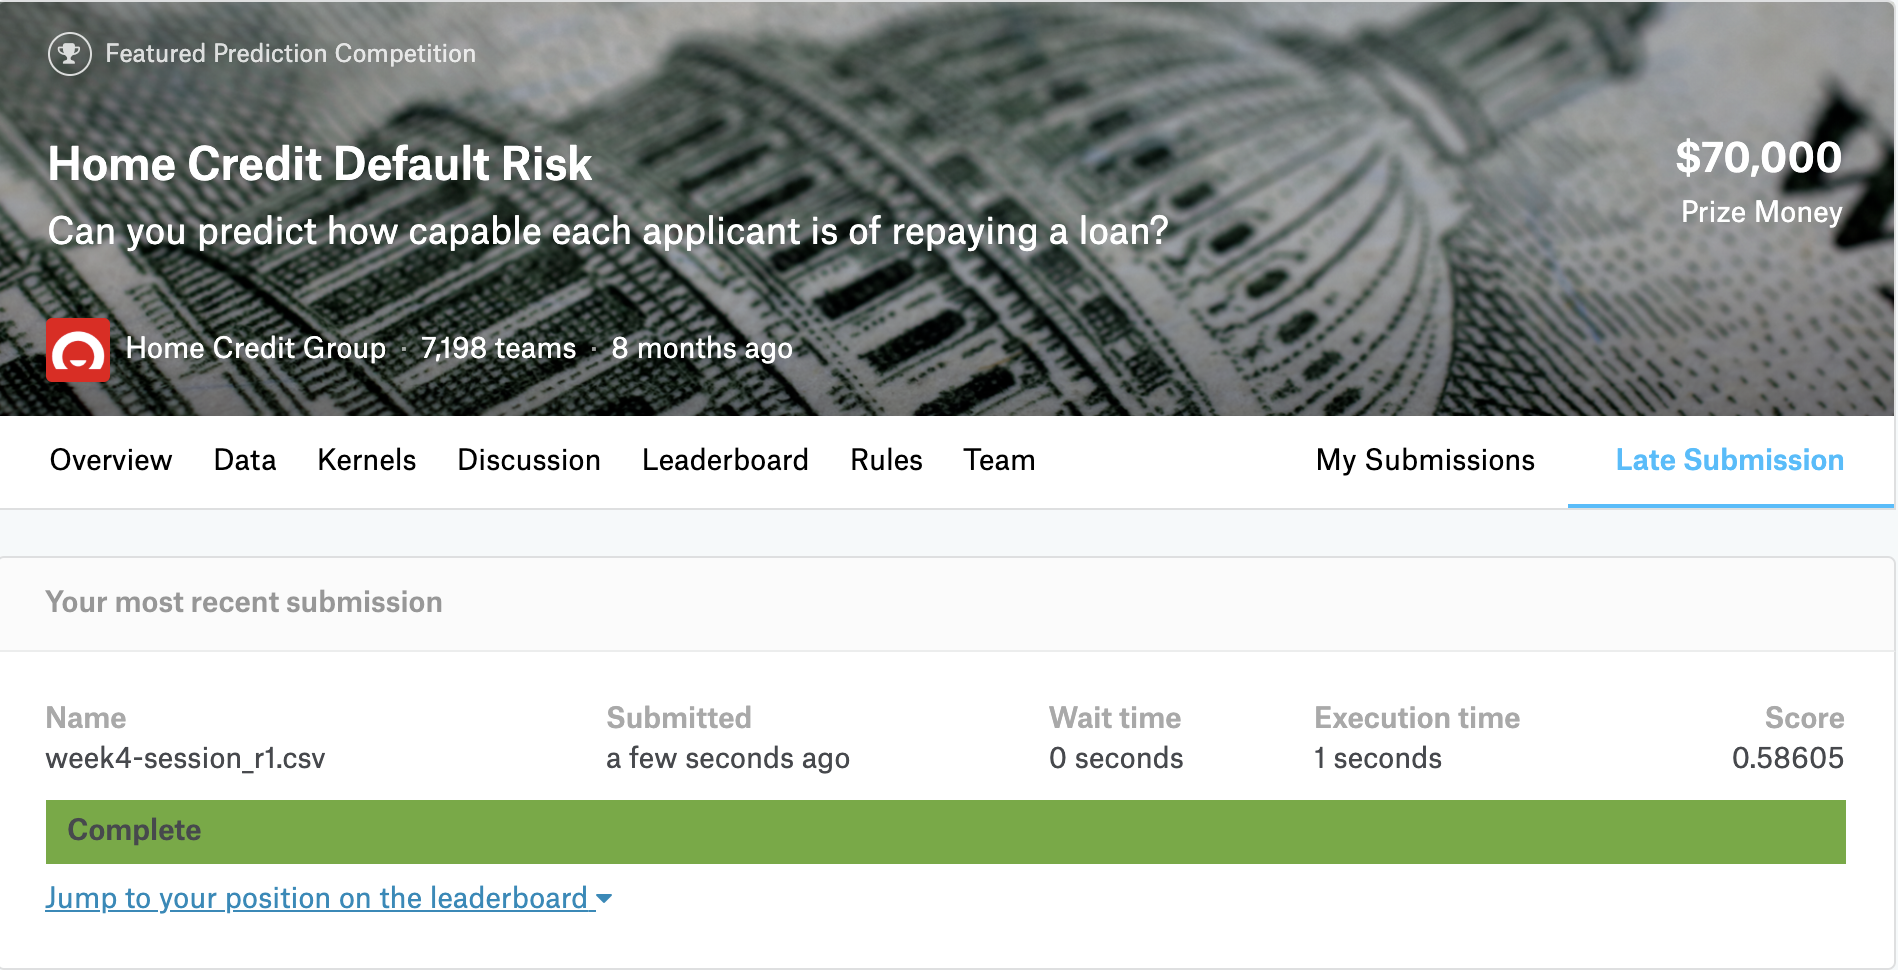

In [32]:
from IPython.display import display
from PIL import Image
#isplay(Image.open('../input/upload/week4-session_r1_score.png'))
display(Image.open('week4-session_r1_score.png'))

# 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）このAUCを計算する関数を作成してください。

### 関数定義

In [93]:
# metricsライブラリをインポートする
from sklearn import metrics

# 関数compute_aucを定義
def compute_auc(y_true, y_pred, pos_label):
    
    """
ROCカーブのAUCを計算
Parameters
----------
Input:
    y_true:int→正解データ
    
    y_pred:float→予測確率
    
    pos_label:int→Positiveとするラベル
Retun:
    auc:float→ROCカーブのAUC
"""
    # 入力データをnumpy配列化
    y_true = np.array(y_true).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    
    # roc_curveメソッドでfpr, tpr, thresholdを計算
    fpr, tpr, thresholds = metrics.roc_curve(y_true, pred, pos_label=pos_label)
    
    # aucメソッドでaucを計算
    auc = metrics.auc(fpr, tpr)
    
    return auc

### 動作確認

In [94]:
# 動作確認の為、以下のnumpy配列を作成する

# 正解データ
true = np.array([1, 1, 2, 2])

# 予測確率
pred = np.array([0.1, 0.4, 0.35, 0.8])

auc = compute_auc(true, pred, pos_label=2)
auc

0.75

In [35]:
true

array([1, 1, 2, 2])

In [36]:
pred

array([0.1 , 0.4 , 0.35, 0.8 ])

# 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。

汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

### データ準備
#### 前処理を１度で完了させる為にtrainデータの特徴量とtestデータの特徴量を縦に結合する)¶
- 精度向上やFeatureEngineeringではないが、作業効率向上の為に実施

In [39]:
# テストデータを読み込み、先頭から５行のみ表示
df_train = pd.read_csv('application_train.csv') # train.csvをデータフレーム形式で読み込んで表示
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [40]:
# trainデータの特徴量のみ抽出
train_feature = df_train.iloc[:, 2:]
train_feature.shape

(307511, 120)

In [41]:
# trainデータの目的変数を抽出
train_label = df_train.iloc[:,1]
train_label.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [42]:
# テストデータを読み込み、先頭から５行のみ表示
df_test = pd.read_csv('application_test.csv') # train.csvをデータフレーム形式で読み込んで表示
df_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

              ...             FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                            0                0   
1             ...                            0                0   
2             ...                            0                0   
3             ...                            0                0   
4             ...                            0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        0.0   
4                0                0                        NaN   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        NaN                         NaN   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         0.0  
1                         3.0  
2                         4.0  
3                         3.0  
4                         NaN  

[5 rows x 121 columns]

In [43]:
# testデータの特徴量のみ抽出
test_feature = df_test.iloc[:, 1:]
test_feature.shape

(48744, 120)

In [44]:
# trainデータとtestデータを縦に結合
df_concat = pd.concat([train_feature, test_feature])
df_concat.shape

(356255, 120)

## 以下に問題１からの修正内容を記載する
## 前処理
#### 修正前
- カテゴリカル変数をget_dummyメソッドにてOneHotEncoding
- 欠損値はゼロ補完
- 目的変数(TARGET)と相関係数の高い特徴量上位10個を学習データとする
- train_test_splitメソッドにてtrainデータを学習データ75%、テストデータ25%で分割

#### 修正・追加箇所
1. **欠損値**
    - <u>欠損率が6割以上は削除、マルチラベルのデータは最頻値、それ以外の数値データは平均値で補完。</u>
    
## モデル作成・評価
#### 修正前
- StandardScalerクラスによる正規化
- PCAクラスによる次元削減
- KNeighborsClassifierモデルを使用
    
#### 修正・追加箇所
1. **パラメータ修正**
    - <u>KNeighborsClassifierのn_neighborsパラメータをデフォルトの5から10に変更</u>
2. 学習モデルの追加
    - <u>RandomForestClassifierモデルの追加</u>

## 前処理

### カテゴリカル変数をget_dummyメソッドにてOneHotEncoding

In [45]:
df_concat_dummies = pd.get_dummies(df_concat)
df_concat_dummies.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH           ...             HOUSETYPE_MODE_terraced house  \
0            -2120           ...                                         0   
1             -291           ...                                         0   
2            -2531           ...                                         0   
3            -2437           ...                                         0   
4            -3458           ...                                         0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                         0                         0   
1                         1                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                          0                       1                        0  
1                          0                       1                        0  
2                          0                       0                        0  
3                          0                       0                        0  
4                          0                       0                        0  

[5 rows x 244 columns]

### 欠損率が6割以上は削除、マルチラベルのデータは最頻値、それ以外の数値データは平均値で補完。

In [46]:
# 欠損値の数(初期値 0)
missing_value_number = 0

# df_concat_dummiesの行数を取得
df_length = len(df_concat_dummies)

# データのcolomusを１つずつ取得し、変数colに格納
for col in df_concat_dummies.columns:
    
    #col列の欠損値の数をmissing_value_numberに格納
    missing_value_number = df_concat_dummies[col].isnull().sum()
    
    # 欠損値の数が1以上か判別
    if missing_value_number > 0:
        
        # 1以上→欠損値の割合が60%以上か判別
        if missing_value_number/df_length >= 0.6:
            
            # 60%以上→col列を削除
            df_concat_dummies = df_concat_dummies.drop(col, axis=1)
        # 60%以下
        else:
            
            # col列のデータタイプがオブジェクト型か判別
            if df_concat_dummies[col].dtype == object:
                
                # オブジェクト型→欠損値を最頻値で補完
                df_concat_dummies[col] = df_concat_dummies[col].fillna(train[col].mode()[0])
                
            else:
                
                # 非オブジェクト型→欠損値を平均値で補完
                df_concat_dummies[col] = df_concat_dummies[col].fillna(df_concat_dummies[col].mean())

In [47]:
# 欠損値が６割以上の特徴量の列が削減されている事を確認
df_concat_dummies.shape

(356255, 228)

### 目的変数(TARGET)相関係数の高い特徴量上位10個を学習データとする

In [48]:
# 問題１で作成したデータから目的変数(TARGET)相関係数の高い特徴量上位20個を
top10_index = feature_corr_target_sort[:10].index
top10_index

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M'],
      dtype='object')

In [49]:
df_concat_dummies_top10 = df_concat_dummies.loc[: , top10_index]
df_concat_dummies_top10.head()

EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1  \
0      0.262949      0.139376       -9461      0.083037   
1      0.622246      0.509350      -16765      0.311267   
2      0.555912      0.729567      -19046      0.501965   
3      0.650442      0.509350      -19005      0.501965   
4      0.322738      0.509350      -19932      0.501965   

   REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  \
0                            2                     2   
1                            1                     1   
2                            2                     2   
3                            2                     2   
4                            2                     2   

   NAME_INCOME_TYPE_Working  NAME_EDUCATION_TYPE_Higher education  \
0                         1                                     0   
1                         0                                     1   
2                         1                                     0   
3                         1                                     0   
4                         1                                     0   

   DAYS_LAST_PHONE_CHANGE  CODE_GENDER_M  
0                 -1134.0              1  
1                  -828.0              0  
2                  -815.0              1  
3                  -617.0              0  
4                 -1106.0              1

### 前処理したデータをtrainデータとtestデータに分割

In [51]:
# 上から307511行はtrainデータ
df_train_preprocessing = df_concat_dummies_top10.iloc[:307511, :]
df_train_preprocessing.shape

(307511, 10)

In [52]:
# 307511行より下はtestデータ
df_test_preprocessing = df_concat_dummies_top10.iloc[307511:, :]
df_test_preprocessing.shape

(48744, 10)

### trainデータをモデル作成用とモデル評価用に分割する

In [53]:
# trainデータを分割　学習データは75%で設定
X_train, X_test, y_train, y_test = train_test_split(df_train_preprocessing, 
                                                    train_label, 
                                                    test_size = 0.25, 
                                                    random_state = 0)

In [58]:
# Pipelineを定義　正規化→PCA→各モデルでの学習　の流れ
pipelines ={
    'knn_5': Pipeline([('scl',StandardScaler()),
                       ('pca',PCA()),
                       ('est',KNeighborsClassifier())]),
  
    'knn_10': Pipeline([('scl',StandardScaler()),
                        ('pca',PCA()),
                        ('est',KNeighborsClassifier(n_neighbors=10))]),
    
    'rfc': Pipeline([('scl',StandardScaler()),
                    ('pca',PCA()),
                    ('est',RandomForestClassifier())]) 
}

### 学習モデルの作成、予測

In [59]:
# 予測結果を格納する辞書
predict_dict = {}

# 予測確率を計算する辞書
predict_proba_dict = {}

# for文で各Pipelineを抽出し、
#pipe_nameに辞書のキーが、pipelineにPipelineクラスのインスタンスが格納される
for pipe_name, pipeline in pipelines.items():
    
    # 学習
    pipeline.fit(X_train,y_train)
    
    # 予測し辞書に格納
    predict_dict[pipe_name] = pipeline.predict(X_test)
    
    # 予測確率を計算し、辞書に格納
    predict_proba_dict[pipe_name] = pipeline.predict_proba(X_test)

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt

In [60]:
# 各モデルの予測結果
predict_dict

{'knn_5': array([0, 0, 0, ..., 0, 0, 0]),
 'knn_10': array([0, 0, 0, ..., 0, 0, 0]),
 'rfc': array([0, 0, 0, ..., 0, 0, 0])}

In [61]:
# 各モデルの予測確率
predict_proba_dict

{'knn_5': array([[0.6, 0.4],
        [1. , 0. ],
        [0.6, 0.4],
        ...,
        [1. , 0. ],
        [0.8, 0.2],
        [0.8, 0.2]]), 'knn_10': array([[0.6, 0.4],
        [1. , 0. ],
        [0.7, 0.3],
        ...,
        [1. , 0. ],
        [0.8, 0.2],
        [0.9, 0.1]]), 'rfc': array([[0.5, 0.5],
        [1. , 0. ],
        [1. , 0. ],
        ...,
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ]])}

### 評価

In [62]:
# nameに各モデルの名前　predictに予測結果を格納
for name, predict in predict_dict.items():
    
    # 評価値を表示
    print(name)
    print('Accuracy_Score : {}'.format(accuracy_score(y_test, predict)))
    print('Precision_Score : {}'.format(precision_score(y_test, predict)))
    print('Recall_Score : {}'.format(recall_score(y_test, predict)))
    print('F1_Score : {}\n'.format(f1_score(y_test, predict)))

knn_5
Accuracy_Score : 0.9129659980748719
Precision_Score : 0.2540983606557377
Recall_Score : 0.050894762764734855
F1_Score : 0.084803720421283

knn_10
Accuracy_Score : 0.919781992247457
Precision_Score : 0.3582089552238806
Recall_Score : 0.015760958791659826
F1_Score : 0.030193426639408712

rfc
Accuracy_Score : 0.9163219646712973
Precision_Score : 0.27320954907161804
Recall_Score : 0.03382039074043671
F1_Score : 0.06018991964937912



### AUCを計算

In [96]:
# 各モデルでのAUCを格納する辞書
auc_dict = {}

# nameにモデル名　y_predに予測確率を格納
for name, y_pred in predict_proba_dict.items():
    
    #fpr, tpr, thresholds = metrics.roc_curve(true, pred, pos_label=2)
    auc_dict[name] = compute_auc(true, pred, pos_label=1)

In [64]:
auc_dict

{'knn_5': 0.25, 'knn_10': 0.25, 'rfc': 0.25}

### 機械学習モデルにテストデータを読み込ませ、目的変数TARGETが1である確率を求める

In [68]:
# 予測結果を格納するリスト
test_predict_proba_dict = {}

# for文で各Pipelineを抽出し、
#pipe_nameに辞書のキーが、pipelineにPipelineクラスのインスタンスが格納される
for pipe_name, pipeline in pipelines.items():
    
    # 学習
    pipeline.fit(X_train,y_train)
    
    # 予測
    test_predict_proba_dict[pipe_name] = pipeline.predict_proba(df_test_preprocessing)

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardSc

In [69]:
# 各モデルの検証データでのTARGT = 1の予測確率
test_predict_proba_dict

{'knn_5': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]), 'knn_10': array([[0.9, 0.1],
        [0.9, 0.1],
        [1. , 0. ],
        ...,
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ]]), 'rfc': array([[1. , 0. ],
        [0.6, 0.4],
        [0.8, 0.2],
        ...,
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ]])}

### 各モデルの予測確率をリスト形式に変換

In [70]:
knn_5_proba_list = test_predict_proba_dict['knn_5'][:,1].reshape(-1,1)
knn_5_proba_list.shape

(48744, 1)

In [71]:
rfc_proba_list = test_predict_proba_dict['rfc'][:,1].reshape(-1,1)
rfc_proba_list.shape

(48744, 1)

In [72]:
knn_10_proba_list = test_predict_proba_dict['knn_10'][:,1].reshape(-1,1)
knn_10_proba_list.shape

(48744, 1)

### 各モデルの予測確率をデータフレームに変換

In [73]:
knn_5_proba_df = pd.DataFrame(knn_5_proba_list, columns=['TARGET'])
knn_5_proba_df.head()

TARGET
0     0.0
1     0.0
2     0.0
3     0.4
4     0.2

In [74]:
knn_10_proba_df = pd.DataFrame(knn_10_proba_list, columns=['TARGET'])
knn_10_proba_df.head()

TARGET
0     0.1
1     0.1
2     0.0
3     0.3
4     0.1

In [75]:
rfc_proba_df = pd.DataFrame(rfc_proba_list, columns=['TARGET'])
rfc_proba_df.head()

TARGET
0     0.0
1     0.4
2     0.2
3     0.1
4     0.4

### テストデータのID列と横に結合

In [76]:
submission_knn_5_df = pd.concat([df_test_id, knn_5_proba_df], axis=1)
submission_knn_5_df.head()

SK_ID_CURR  TARGET
0      100001     0.0
1      100005     0.0
2      100013     0.0
3      100028     0.4
4      100038     0.2

In [77]:
submission_knn_10_df = pd.concat([df_test_id, knn_10_proba_df], axis=1)
submission_knn_5_df.head()

SK_ID_CURR  TARGET
0      100001     0.0
1      100005     0.0
2      100013     0.0
3      100028     0.4
4      100038     0.2

In [78]:
submission_rfc_df = pd.concat([df_test_id, rfc_proba_df], axis=1)
submission_rfc_df.head()

SK_ID_CURR  TARGET
0      100001     0.0
1      100005     0.4
2      100013     0.2
3      100028     0.1
4      100038     0.4

In [79]:
submission_knn_5_df.to_csv("week4-session-3_knn-5_submission.csv", index=False, encoding='utf-8')

In [80]:
submission_knn_10_df.to_csv("week4-session-3_knn-10_submission.csv", index=False, encoding='utf-8')

In [81]:
submission_rfc_df.to_csv("week4-session-3_rfc_submission.csv", index=False, encoding='utf-8')

### Kaggleに予測結果を提出しscoreを確認
### knn(n_neighbors=5)　→　score 0.58726

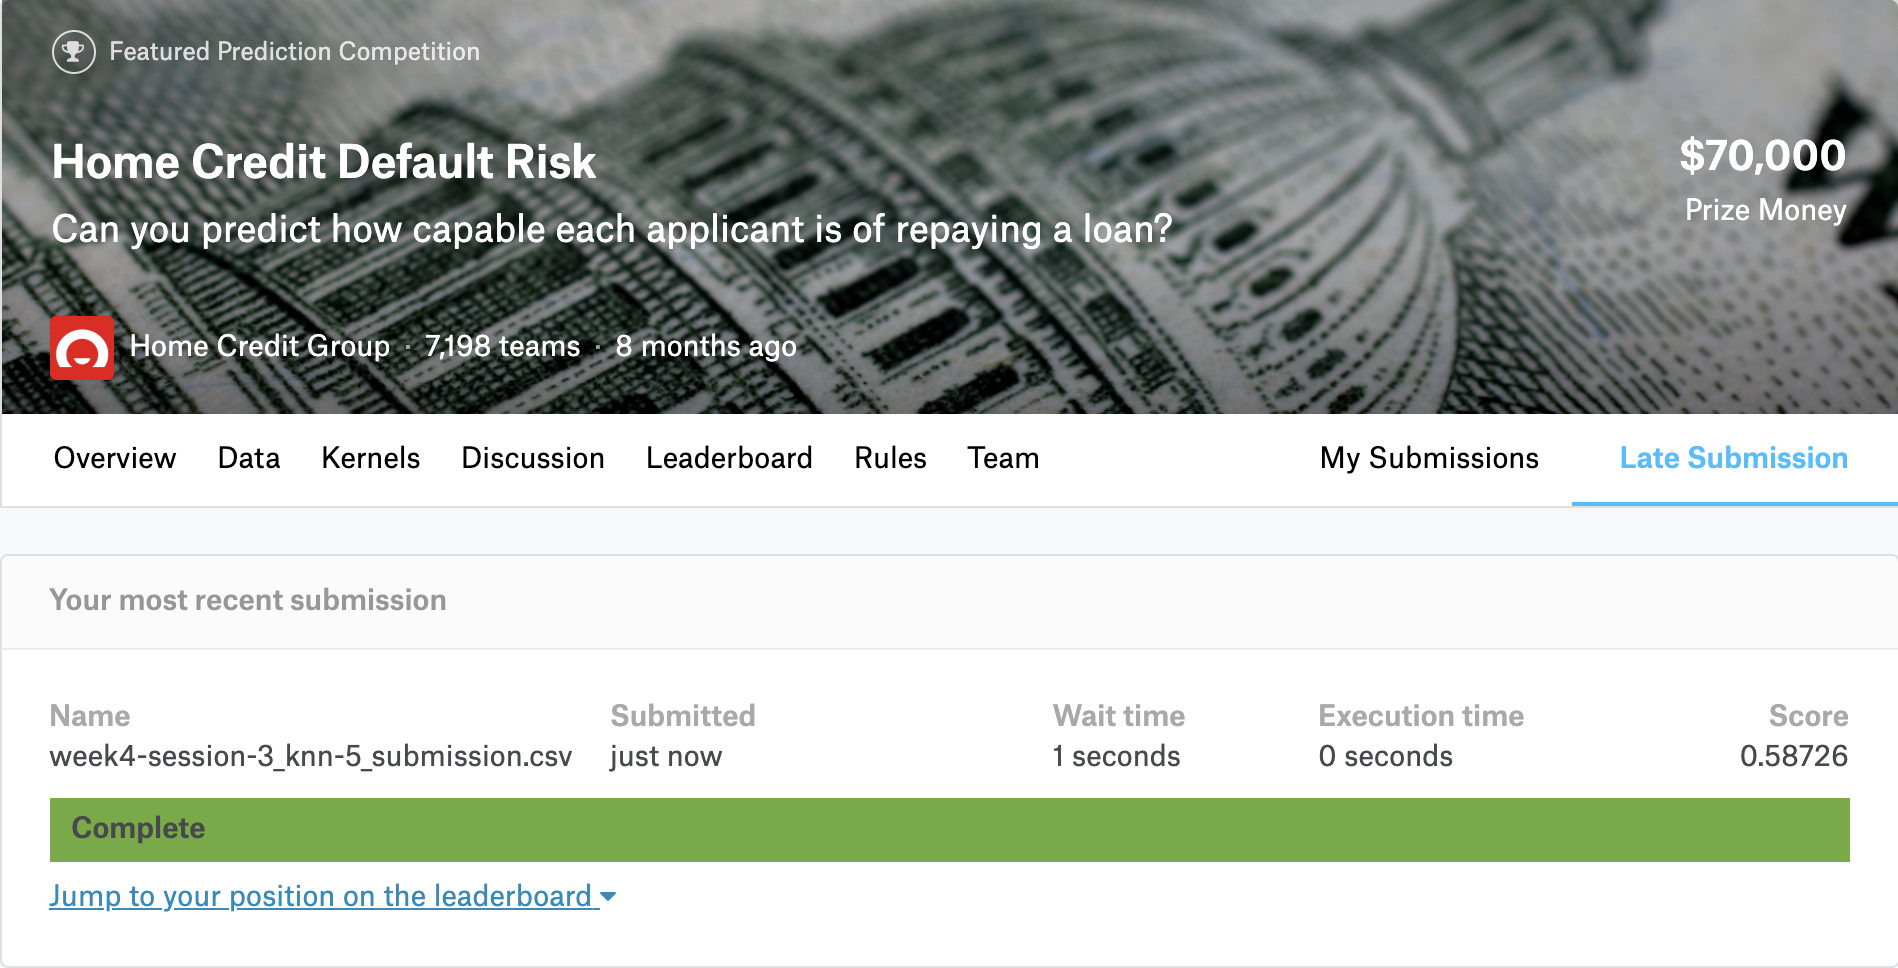

In [91]:
display(Image.open('week4-session-3_knn-5_score.png'))

### knn(n_neighbors=10)　→　score 0.62505

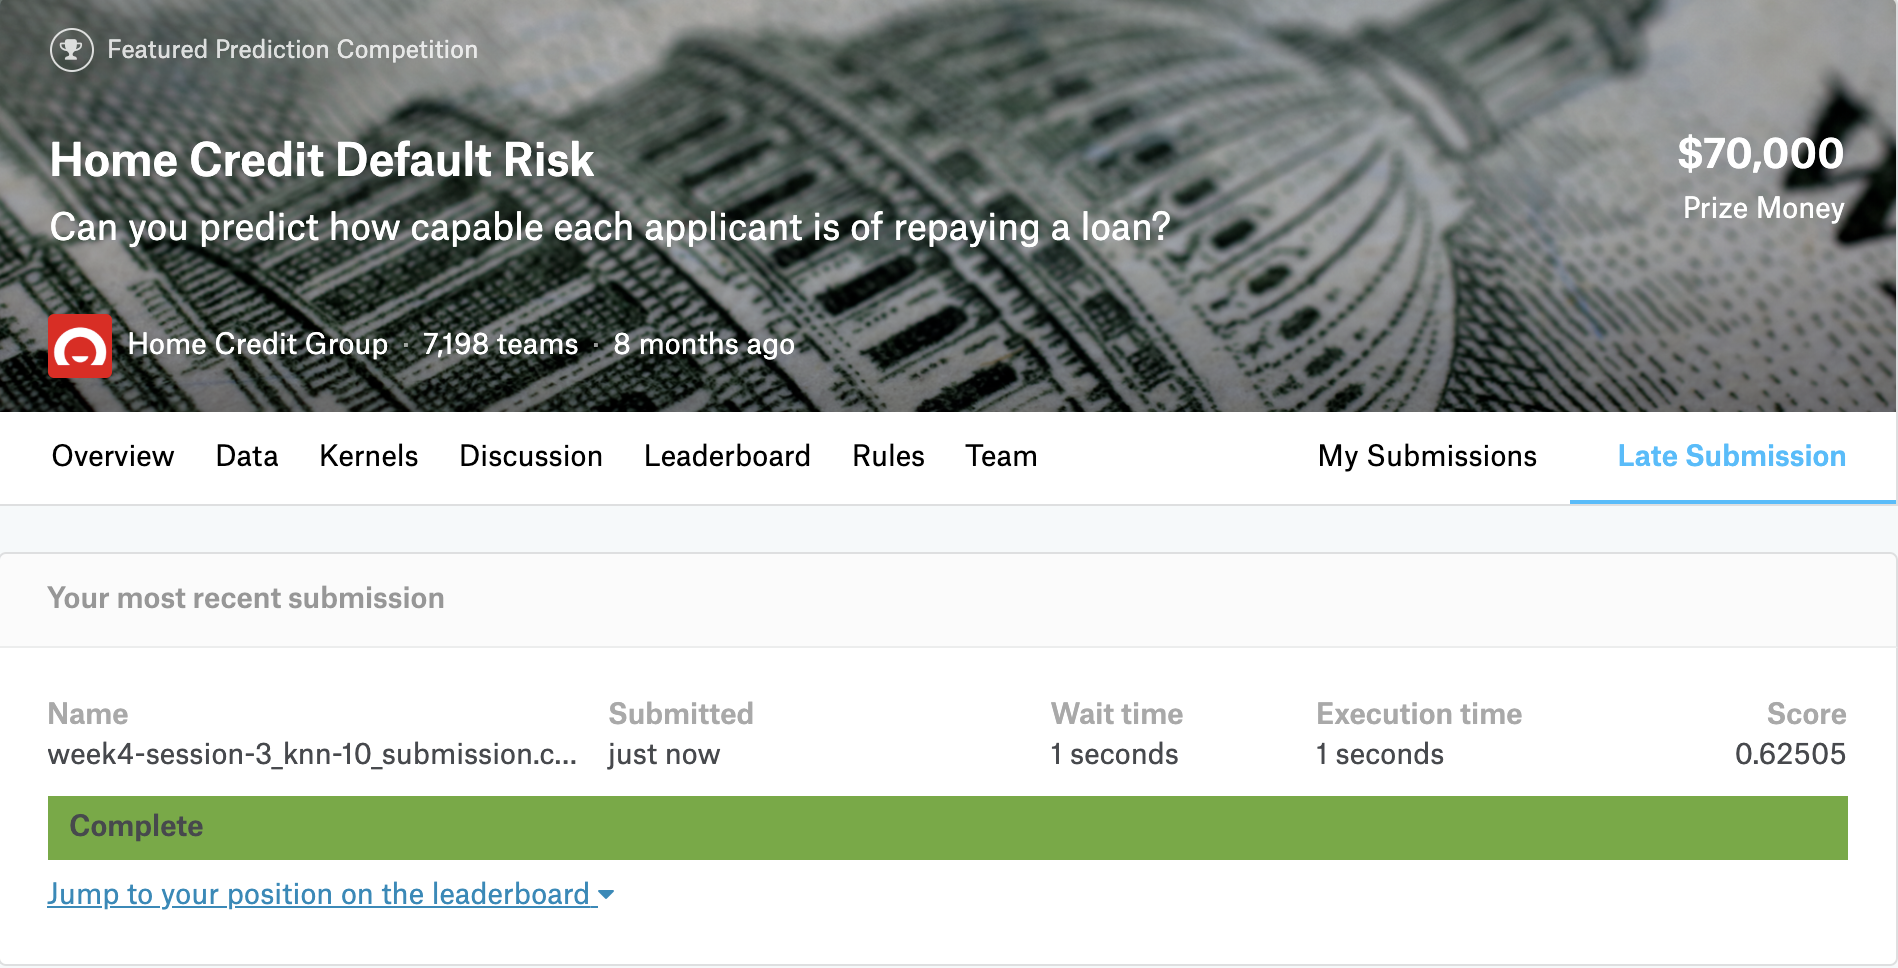

In [88]:
display(Image.open('week4-session-3_knn-10_score.png'))

### knn(n_neighbors=5)　→　score 0.61871

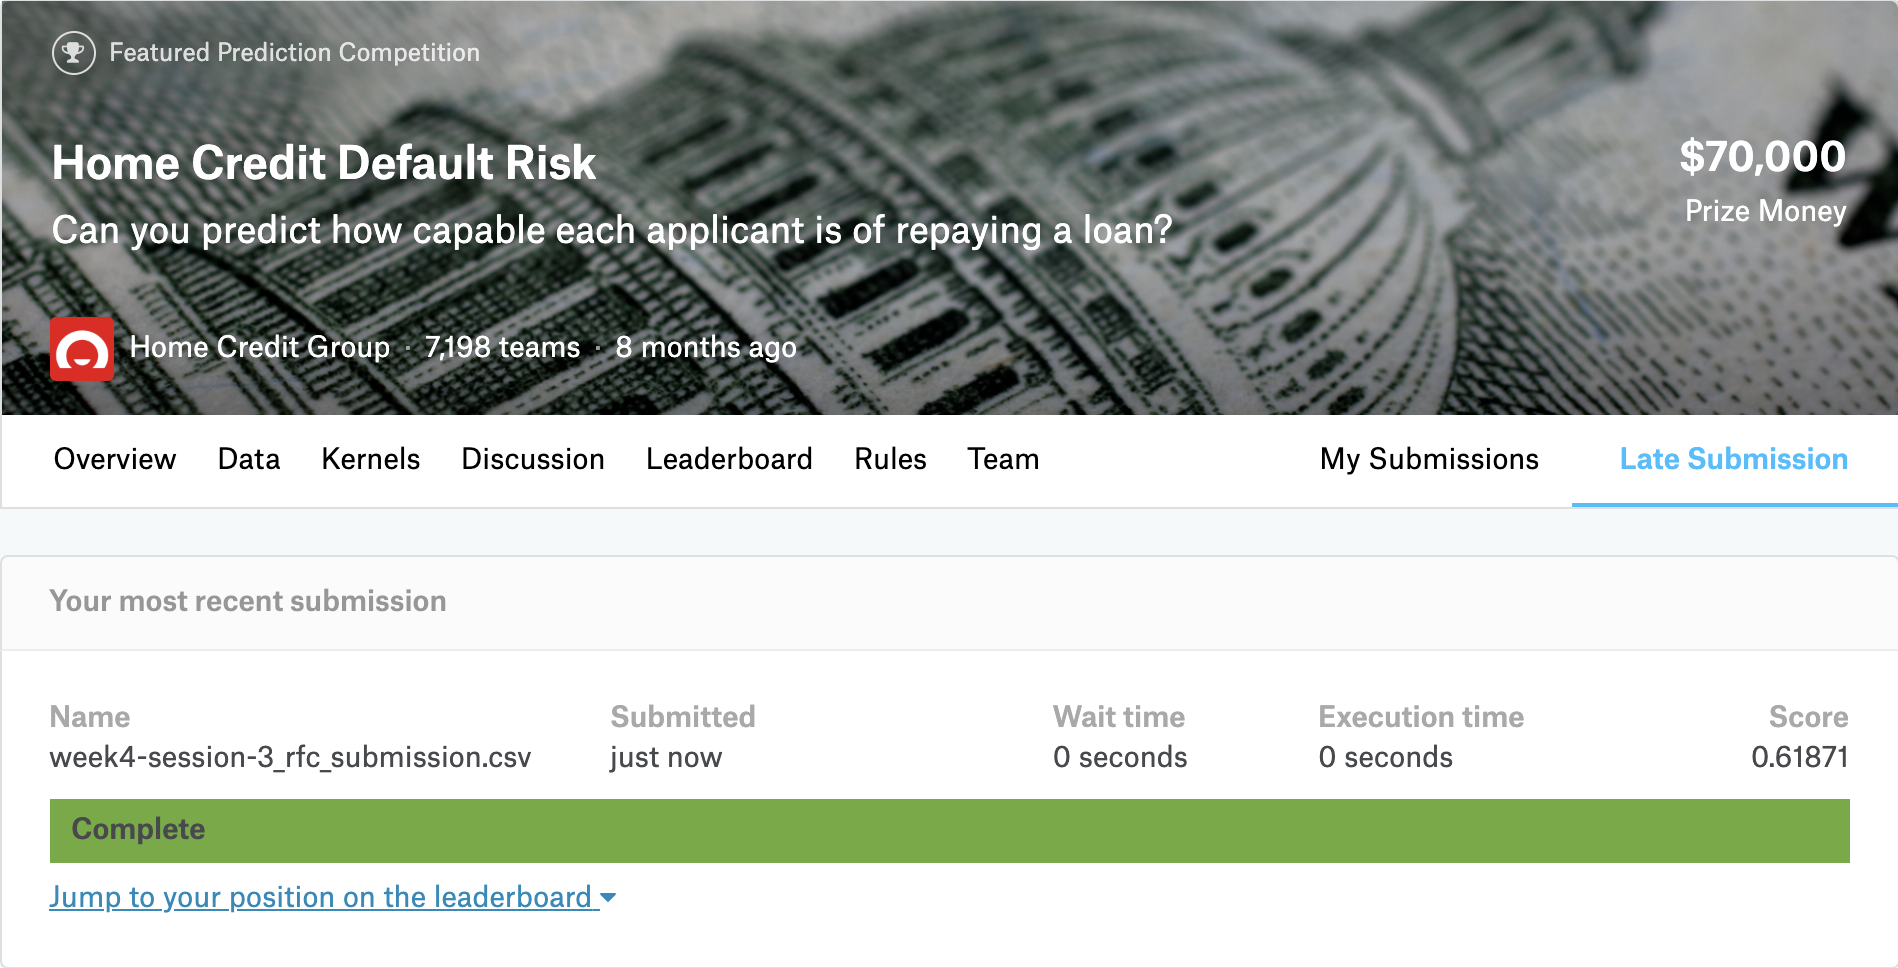

In [89]:
display(Image.open('week4-session-3_rfc_score.png'))